#LSTM NN con MNIST, versione GPU

*Long-Short Term Memory* neural network sviluppata in TensorFlow versione 1.x, su database MNIST; costruita per usufruire della GPU, ossia con CuDNN.

In [52]:
%tensorflow_version 1.x

In [53]:
import tensorflow as tf
from tensorflow import keras as ks

#tf.reset_default_graph()

#RNN Cells and additional RNN operations.
#contrib è un modulo "sperimentale" in TF 1.x; aggiunto in TF 2.x
#from tensorflow.contrib import rnn
#Preferisco utilizzare keras (come built-in in TensorFlow) che le strutture in tf

print(tf.__version__)

1.15.2


In [54]:
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

import time

print("Done")

Done


##Devices utilizzati

Test per vedere che device sono utilizzati.

In [55]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16796909218906855051
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7362437653890392096
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8852705420865003255
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17280811448516858743
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


##Altri metodi

In [56]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

print("Done")

Done


In [57]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

print("Done")

Done


##Import dei dati

In [58]:
#Import del database MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#Struttura dati nel database
print("Numero elementi e dimensione immagini in train set: " + str(train_images.shape))
print("Numero elementi e dimensione immagini in test set: " + str(test_images.shape))
print("Numero elementi label in train set: " + str(len(train_labels)))
print("Numero elementi label in test set: " + str(len(test_labels)))
print("Tipo di struttura del train set: " + str(type(train_images)) + ", composto da " + str(type(train_images[0])))
print("Tipo di struttura del label set: " + str(type(train_labels)) + ", composto da " + str(type(train_labels[0])))
print("Le etichette sono interi; valore più piccolo: " + str(np.amin(train_labels)) + ", valore più grande: " + str(np.amax(train_labels)))

Numero elementi e dimensione immagini in train set: (60000, 28, 28)
Numero elementi e dimensione immagini in test set: (10000, 28, 28)
Numero elementi label in train set: 60000
Numero elementi label in test set: 10000
Tipo di struttura del train set: <class 'numpy.ndarray'>, composto da <class 'numpy.ndarray'>
Tipo di struttura del label set: <class 'numpy.ndarray'>, composto da <class 'numpy.uint8'>
Le etichette sono interi; valore più piccolo: 0, valore più grande: 9


##Costanti e parametri

In [59]:
#Costanti
batch_size = 128
time_steps = 28
n_features = 28
n_classes = 10

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

#unused
num_batches = int(len(train_labels) / batch_size)

#Activation dell'ultimo layer, dense
act = 'softmax'

#Optimizer
opt = 'adam'
#opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

print("Done")

Done


##Preprocessing dei dati

In [60]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


In [61]:
train_images = train_images.reshape(-1, time_steps, n_features)

test_images = test_images.reshape(-1, time_steps, n_features)

print("Done")

Done


#Definizione modello

##Build

In [62]:
modelLSTM = ks.Sequential()

#no activation selection
modelLSTM.add(CuDNNLSTM(num_units1, input_shape=(time_steps, n_features), return_sequences='true'))
modelLSTM.add(CuDNNLSTM(num_units2))
modelLSTM.add(Dense(n_classes, activation=act))

print("Done")

Done


##Compile

In [63]:
modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

modelLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 28, 128)           80896     
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 131,210
Trainable params: 131,210
Non-trainable params: 0
_________________________________________________________________


##Fit del modello

In [64]:
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = modelLSTM.fit(train_images, train_labels, 
                     batch_size = batch_size,
                     validation_data=(test_images, test_labels), 
                     epochs=100,
                     callbacks=[time_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 56us/sample - loss: 0.4960 - acc: 0.8385 - val_loss: 0.1783 - val_acc: 0.9469
Epoch 2/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1429 - acc: 0.9562 - val_loss: 0.1077 - val_acc: 0.9671
Epoch 3/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0921 - acc: 0.9729 - val_loss: 0.0911 - val_acc: 0.9723
Epoch 4/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0689 - acc: 0.9789 - val_loss: 0.0818 - val_acc: 0.9765
Epoch 5/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0565 - acc: 0.9827 - val_loss: 0.0771 - val_acc: 0.9772
Epoch 6/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0473 - acc: 0.9857 - val_loss: 0.0448 - val_acc: 0.9862
Epoch 7/100
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0376 - acc: 0.9884 - val_l

##Risultati

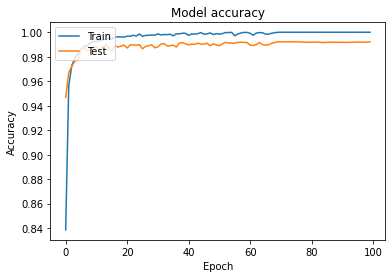

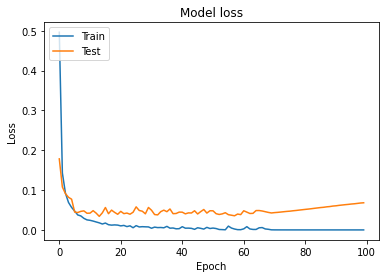

Time per epoch: [3.3376126289367676, 2.9389731884002686, 2.9193758964538574, 2.9474918842315674, 2.9452242851257324, 2.9404056072235107, 2.936556577682495, 2.9263250827789307, 2.91079044342041, 2.9590747356414795, 2.943582534790039, 2.963702440261841, 2.9865195751190186, 2.9166595935821533, 2.924882173538208, 2.9506490230560303, 2.9457123279571533, 2.9691343307495117, 2.9504098892211914, 2.9391298294067383, 2.928828716278076, 2.9556033611297607, 2.983912229537964, 2.9538819789886475, 2.952280044555664, 2.958597183227539, 2.9315154552459717, 2.9605140686035156, 2.9526736736297607, 2.935347318649292, 2.961571455001831, 2.9524896144866943, 2.9739067554473877, 2.9422295093536377, 2.9373583793640137, 2.912233352661133, 2.923497200012207, 2.9587714672088623, 2.954310894012451, 2.9692959785461426, 2.966266632080078, 2.9327385425567627, 2.8984367847442627, 2.940680503845215, 2.952136278152466, 2.9377973079681396, 2.947880506515503, 2.9664082527160645, 2.960089921951294, 2.970111608505249, 2.93

In [65]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [66]:
#Necessito di un array con tutte le labels
classes=[0,1,2,3,4,5,6,7,8,9]

test_predictions = modelLSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

[[ 975    0    0    0    1    0    3    1    0    0]
 [   1 1132    0    0    0    0    1    1    0    0]
 [   1    0 1030    0    0    0    0    1    0    0]
 [   0    0    3 1003    0    2    0    0    2    0]
 [   0    0    0    0  969    0    5    1    0    7]
 [   0    0    1    4    0  882    1    1    2    1]
 [   1    2    1    0    1    4  948    0    1    0]
 [   0    3    6    0    0    0    0 1014    0    5]
 [   0    0    1    1    0    0    0    2  969    1]
 [   0    0    0    1    5    0    0    3    0 1000]]


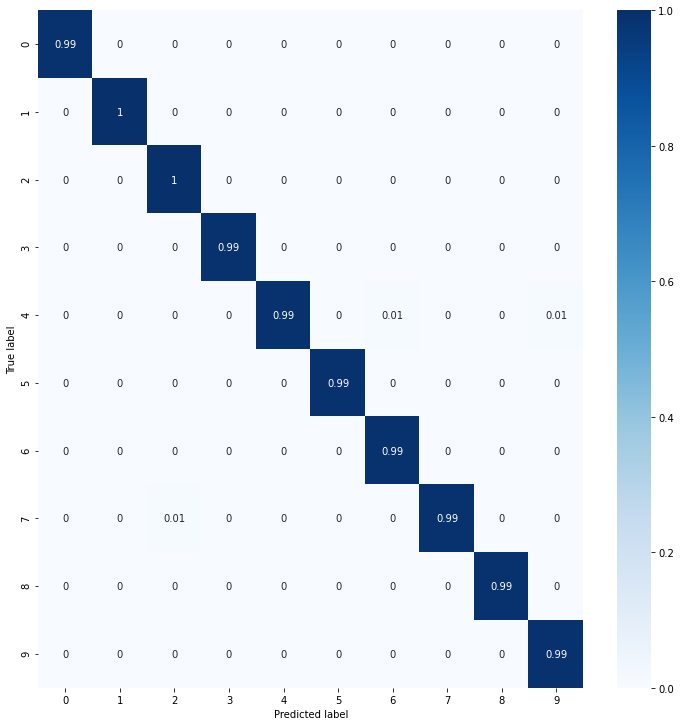

In [67]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()